The AUC for current fold is: 0.6018379573738308
The AUC for current fold is: 0.654508797653959
The AUC for current fold is: 0.715962441314554
The AUC for current fold is: 0.7235383856059587
The AUC for current fold is: 0.6541031518624643
The best AUC is 0.7235383856059587


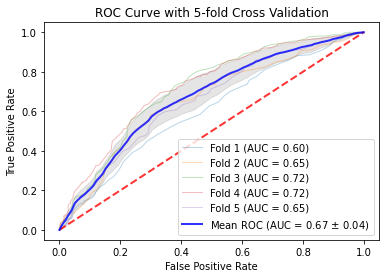

Best AUC achieved: 0.72


In [1]:
# Appendix 2: Classification Model based on Random Forest Algorithm

# Importing required libraries
# Importing libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling inline plotting for matplotlib
%matplotlib inline

# Importing libraries for model selection and evaluation
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    auc, 
    classification_report, 
    confusion_matrix
)

%matplotlib inline


# Define the path of the dataset
dataset_path = 'your_file_path.xlsx'

# Load the dataset
client_info = pd.read_excel(dataset_path)

# Define predictors, target variable 'y', and feature set 'X'
predictors = [col for col in client_info.columns if col not in ['default', 'house', 'card']]
y = client_info['default']
X_continuous = client_info[predictors]
X_categorical = client_info[['house', 'card']].values

# Standardize continuous variables
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)

# Combine continuous and categorical variables to form the final feature set 'X'
X = np.column_stack((X_continuous, X_categorical))

# Perform 5-fold cross-validation and visualize ROC curves
kf = KFold(n_splits=5)
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
best_auc = 0

# Loop through each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Initialize and train the RandomForest Classifier
    clf = RandomForestClassifier()
    clf.fit(X[train_index], y.iloc[train_index])
    
    # Calculate the AUC for current fold
    y_pred = clf.predict_proba(X[test_index])[:, 1]
    fold_auc = roc_auc_score(y.iloc[test_index], y_pred)
    print("The AUC for current fold is:", fold_auc)

    if fold_auc > best_auc:  # Update the best AUC and corresponding indices
        best_auc = fold_auc
        best_train_index = train_index
        best_test_index = test_index
    
    # Compute and plot the ROC curve for each fold
    fpr, tpr, _ = roc_curve(y.iloc[test_index], y_pred)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i + 1} (AUC = {fold_auc:.2f})')
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(fold_auc)

print("The best AUC is", best_auc)

# Configure the plot parameters and plot the mean ROC curve
plt.rcParams['figure.figsize'] = [10, 7]
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

# Fill the area between curves and finalize the plot
plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 5-fold Cross Validation')
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

# Display the best AUC
print(f"Best AUC achieved: {best_auc:.2f}")


In [2]:
# Perform Grid Search to find the optimal parameters for RandomForestClassifier
param_grid = {'n_estimators': [160, 180, 200], 'max_features': [2, 4, 6, 8]}
rf = RandomForestClassifier(random_state=80)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

# Extract the best estimator (model with optimal parameters) from grid search
best_clf = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       276
           1       0.68      0.74      0.71       323

    accuracy                           0.67       599
   macro avg       0.67      0.67      0.67       599
weighted avg       0.67      0.67      0.67       599

ROC AUC Score: 0.7247330282227307


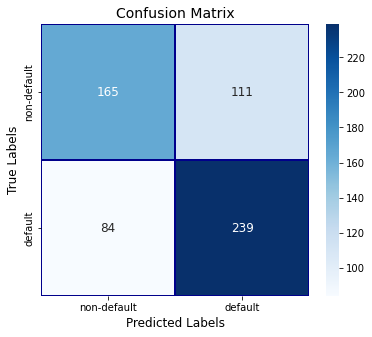

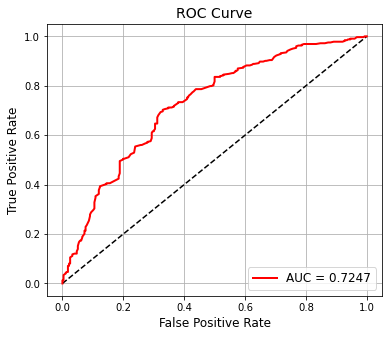

In [3]:
# Assuming best_train_index and best_test_index are some form of array or list.
# If X and y are pandas DataFrame/Series, you may need to convert them to numpy arrays using .values
X_train, X_test = X[best_train_index], X[best_test_index]
y_train, y_test = y[best_train_index], y[best_test_index]

# Train the model and predict
best_clf.fit(X_train, y_train)
predict_results = best_clf.predict(X_test)

# Evaluate the model using classification report and ROC AUC Score
print(classification_report(y_test, predict_results))
roc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:,1])
print(f'ROC AUC Score: {roc}')

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, predict_results),
    annot=True, fmt='d', cmap='Blues', linewidths=.2, linecolor='Darkblue',
    xticklabels=['non-default', 'default'],
    yticklabels=['non-default', 'default'],
    annot_kws={'size': 12}
)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'r', linewidth=2, label=f'AUC = {auc(fpr, tpr):.4f}')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

age        0.246601
working    0.216066
living     0.198518
income     0.156146
member     0.068768
kids       0.041374
card       0.037699
house      0.034828
dtype: float64


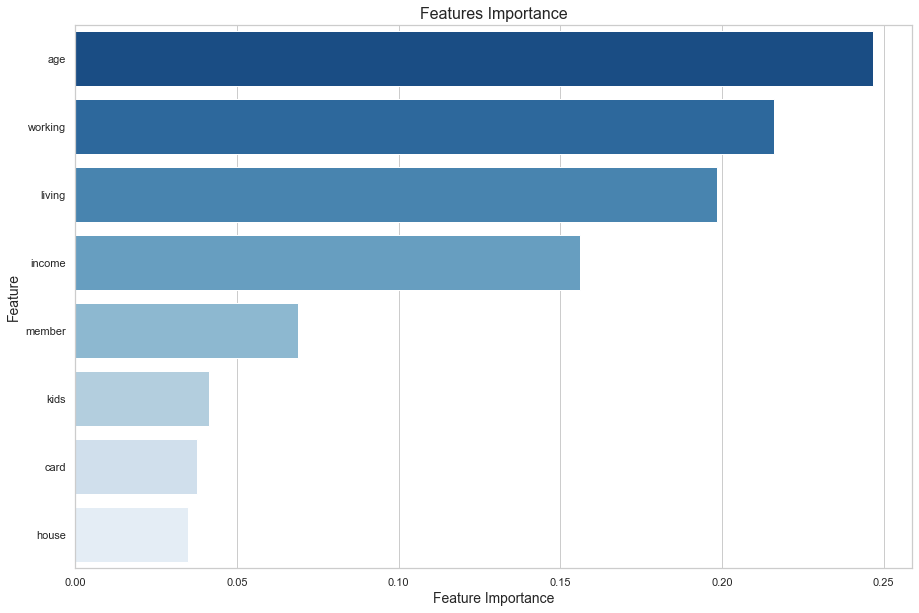

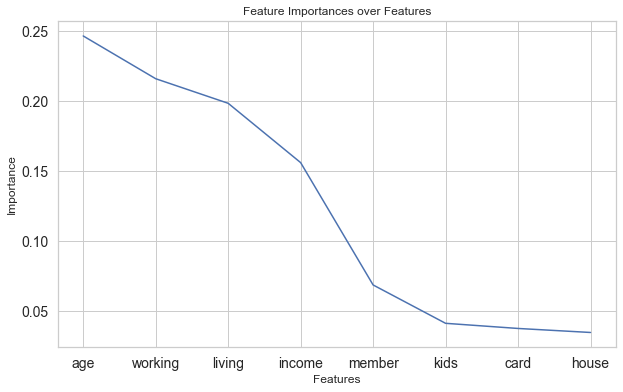

In [4]:
def plot_feature_importance(client_info, clf):
    """
    This function receives the dataframe and trained model,
    calculates the feature importances and plots them.
    
    :param client_info: DataFrame containing client information.
    :param clf: Trained model object with feature_importances_ attribute.
    """
    
    # Extract feature names except 'default' from client_info DataFrame
    feature_names = [col for col in client_info.columns if col != 'default']
    
    # Extracting feature importances from the model
    importances = pd.Series(clf.feature_importances_, index=feature_names)
    
    # Sorting the importances in descending order
    sorted_importances = importances.sort_values(ascending=False)
    
    # Displaying sorted feature importances
    print(sorted_importances)
    
    # Creating a DataFrame for visualization
    tmp = pd.DataFrame({'Feature': feature_names, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance', ascending=False)
    
    # Setting up the matplotlib figure
    plt.figure(figsize=(15, 10))
    sns.set_theme(style="whitegrid")
    
    # Drawing a horizontal bar plot of feature importances
    sns.barplot(x='Feature importance', y='Feature', data=tmp, palette="Blues_r")
    
    # Setting plot title and labels with consistent font size
    plt.title('Features Importance', fontsize=16)
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    
    # Displaying the plot
    plt.show()
    
    # Plotting sorted importances as a line plot for an additional view
    sorted_importances.plot(figsize=(10,6), title='Feature Importances over Features', fontsize=14, color='b')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.show()


# Call the function with appropriate parameters.
plot_feature_importance(client_info, clf)
